# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

_Note_:
- The notebook will run using the results stored in the `output` folder. They were generated using the following:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_reduced_duplication --aug-strategy-test augmentation_with_reduced_duplication --aug-nb-train 70 --aug-nb-test 70 --ml-model CONV1D --eval-strategy True
```
- a `figures` folder will be created in which the images are saved.

📝 Have a look at the [README](https://github.com/volkamerlab/maxsmi/blob/main/README.md) page for more details.

## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- the absolute error between the true value and the average value
- confidence of the prediction: is the standard deviation low or high?

This data represents _only_ the test set (20%) and not the full data (100%).

### Goal
The aim of this notebook is to look at the best models, called the maxsmi models, and see how ensemble learning behaves.

In [1]:
import os
import pandas as pd
import numpy
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import PandasTools, Draw

from utils_analysis import load_results
from utils_smiles import get_num_heavy_atoms
from utils_optimal_model import retrieve_optimal_model

In [2]:
# Path to this notebook
HERE = Path(_dh[-1])

In [3]:
# Make a folder for output figures
os.makedirs("figures", exist_ok=True)

## Dataset
We consider the following datasets:

- ESOL
- lipophilicity
- free solv

Comment/uncomment the dataset of choice in the cell below.

In [4]:
TASK = "lipophilicity"
# TASK = "ESOL"
# TASK = "free_solv"

## Maxsmi models
We retrieve the maxsmi models.

In [5]:
maxsmi_model = retrieve_optimal_model(TASK)
print(f"For the {TASK} data:\n"
      f"the maxsmi deep learning model is: {maxsmi_model[0]}\n"
      f"using an augmentation number of {maxsmi_model[2]} and\n"
      f"augmentation strategy: {maxsmi_model[1].__name__}")

For the lipophilicity data:
the maxsmi deep learning model is: CONV1D
using an augmentation number of 80 and
augmentation strategy: augmentation_with_duplication


## Load data for the maxsmi model on a specific task

In [6]:
maxsmi_data = load_results(TASK,
                         maxsmi_model[1].__name__,
                         maxsmi_model[2],
                         maxsmi_model[1].__name__,
                         maxsmi_model[2],
                         maxsmi_model[0],
                         ensemble_learning=True)
maxsmi_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
3251,-0.91,CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1,"[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...","[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...",0.480339,0.675173
1059,0.75,O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1,"[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...","[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...",0.875117,0.484684
1232,2.97,CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F)...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,3.019065,0.447195
3625,2.33,CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOCC...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,2.281919,0.425678
1925,2.73,CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1,"[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...","[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...",2.625267,0.456863


## Load the canonical counterpart

In [7]:
canonical_data = load_results(TASK,
                              "no_augmentation",
                              0,
                              "no_augmentation",
                              0,
                              maxsmi_model[0],
                              ensemble_learning=True)
canonical_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
3251,-0.91,CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1,[CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1],[CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1],3.148057,0.0
1059,0.75,O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1,[O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1],[O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1],1.241669,0.0
1232,2.97,CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F)...,[CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F...,[CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C$H](CO)c2ccc(F)...,3.188289,0.0
3625,2.33,CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOCC...,[CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOC...,[CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOC...,3.057976,0.0
1925,2.73,CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1,[CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1],[CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1],2.628085,0.0


Merge the tables into one dataframe.

In [8]:
canonical_data = canonical_data.rename(columns={"average_\
prediction": "canonical_prediction"})

In [9]:
data = pd.concat([maxsmi_data, canonical_data["canonical_prediction"]],
                 axis=1)
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction
3251,-0.91,CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1,"[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...","[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...",0.480339,0.675173,3.148057
1059,0.75,O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1,"[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...","[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...",0.875117,0.484684,1.241669
1232,2.97,CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F)...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,3.019065,0.447195,3.188289
3625,2.33,CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOCC...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,2.281919,0.425678,3.057976
1925,2.73,CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1,"[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...","[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...",2.625267,0.456863,2.628085


### Size of molecules
Compute the number of heavy atoms in each molecule.

In [10]:
data["num_heavy_atoms"] = data["canonical_\
smiles"].apply(get_num_heavy_atoms)

## Difference in prediction error with and without augmentation

In [11]:
data["average_error"] = (data["target"] - data["average_prediction"]).abs()
data["canonical_error"] = (data["target"] - data["canonical_prediction"]).abs()
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction,num_heavy_atoms,average_error,canonical_error
3251,-0.91,CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1,"[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...","[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...",0.480339,0.675173,3.148057,19,1.390339,4.058057
1059,0.75,O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1,"[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...","[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...",0.875117,0.484684,1.241669,20,0.125117,0.491669
1232,2.97,CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F)...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,3.019065,0.447195,3.188289,30,0.049065,0.218289
3625,2.33,CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOCC...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,2.281919,0.425678,3.057976,33,0.048081,0.727976
1925,2.73,CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1,"[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...","[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...",2.625267,0.456863,2.628085,22,0.104733,0.101915


In [12]:
def hist_maxsmi_vs_canonical_error(dataframe, task, save_fig=False):
    """
    Add.
    # TODO
    """
    fig, ax = plt.subplots()
    plt.hist(dataframe['canonical_error'], alpha=0.5, bins=numpy.linspace(0, 6, 40))
    plt.hist(dataframe['average_error'], alpha=0.5, bins=numpy.linspace(0, 6, 40))
    ax.legend(["canonical model", "maxsmi model"])
    ax.set_title(f"Histogram of the test errors on the {task} data")
    ax.set_xlabel("error between prediction and true value")
    ax.set_ylabel("frequency")
    
    if save_fig:
        plt.savefig(f"figures/hist_maxsmi_vs_canonical_error_{task}.svg",
            dpi=1200,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format="svg",
            transparent=False,
            bbox_inches=None,
            pad_inches=0.1,)
    
    plt.show()

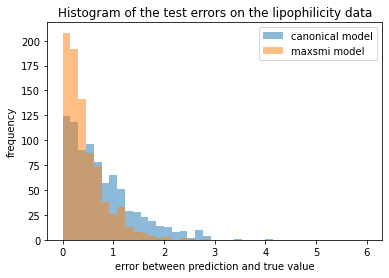

In [13]:
hist_maxsmi_vs_canonical_error(data, TASK, save_fig=True)

### Confidence in the prediction

Now we want to look at how the confidence behaves with respect to the error.

We focus on the maxsmi models which only use augmentation without duplicate, in this case, it was the maxsmi model trained on the free solv data.

Why? If we keep duplicates, then the standard deviation for small compounds will be zero, or close to zero, and so the results would be biased.

We compute the unique number of SMILES per compound:

In [14]:
data["nb_unique_smiles"] = data["augmented_smiles"].apply(lambda x: len(x))
data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,canonical_prediction,num_heavy_atoms,average_error,canonical_error,nb_unique_smiles
3251,-0.91,CCN(c1ccccc1)c1cc(NC)[n+](C)c(C)n1,"[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...","[c1cccc(N(CC)c2cc([n+](C)c(C)n2)NC)c1, c1ccc(N...",0.480339,0.675173,3.148057,19,1.390339,4.058057,80
1059,0.75,O=C(NO)c1ccc(NS(=O)(=O)c2ccccc2)cc1,"[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...","[N(c1ccc(C(=O)NO)cc1)S(=O)(c1ccccc1)=O, O=S(c1...",0.875117,0.484684,1.241669,20,0.125117,0.491669,80
1232,2.97,CC(C)Oc1cc(Nc2nc3c(cc2F)ncn3[C@@H](CO)c2ccc(F)...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,[O(C(C)C)c1cc(n[nH]1)Nc1nc2n([C@H](c3ncc(F)cc3...,3.019065,0.447195,3.188289,30,0.049065,0.218289,80
3625,2.33,CC(C)N(CCNCCc1ccc(O)c2[nH]c(=O)sc12)C(=O)CCOCC...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,[c1cc(ccc1)CCOCCC(=O)N(CCNCCc1ccc(O)c2[nH]c(sc...,2.281919,0.425678,3.057976,33,0.048081,0.727976,80
1925,2.73,CC(C)(O)c1ccc(Nc2nc3ccc(C#N)cc3[nH]2)cc1,"[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...","[[nH]1c(Nc2ccc(C(O)(C)C)cc2)nc2c1cc(C#N)cc2, N...",2.625267,0.456863,2.628085,22,0.104733,0.101915,80


We keep the entries which have a least a mimimum number of unique SMILES: if there is only one, the standard deviation will be zero, and so biased results.

In [15]:
data = data[data["nb_unique_smiles"] > 6]

In [16]:
def scatter_std_dev_vs_error(dataframe, task, save_fig=True):
    """
    Add.
    # TODO
    """
    plt.scatter(data["std_prediction"], data["average_error"])
    plt.xlabel("standard deviation in the prediction")
    plt.ylabel("prediction error")
    plt.title(f"Data: {task}\nMaxsmi model")
    
    if save_fig:
        plt.savefig(f"figures/scatter_std_dev_vs_error_{task}.svg",
            dpi=1200,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format="svg",
            transparent=False,
            bbox_inches=None,
            pad_inches=0.1,)
    
    plt.show()

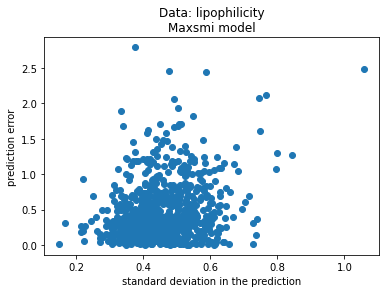

In [17]:
scatter_std_dev_vs_error(data, TASK)